# Rosenblatt perceptron and SVM

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import itertools
from collections import namedtuple
from dataclasses import dataclass

In [2]:
import matplotlib as mpl
mpl.rcParams['axes.grid'] = True  # Use per default a grid, i.e. plt.grid()
# mpl.rcParams['figure.figsize'] = [6.4, 4.8]  # Change the default figure size

In [3]:
# numpy.set_printoptions:
#     threshold: Total number of array elements which trigger summarization rather than full repr (default 1000).
np.set_printoptions(threshold=100)

# Generate different datasets

In [4]:
def map_0_1_to_minus_1_1(labels):
    """
    ??? Add a doc string. What does this function do? What are the input parameters? Which shape?
    """
    return 2 * labels - 1
# REPLACE
map_0_1_to_minus_1_1(np.array([0, 0, 1, 1, 0]))# REPLACE

array([-1, -1,  1,  1, -1])

In [5]:
@dataclass
class Dataset:
    name: str
    features: np.array
    labels: np.array

In [6]:
def generate_circles_dataset(number_of_samples=1000, random_state=np.random):
    labels = random_state.choice([0, 1], size=number_of_samples)
    features = random_state.normal(size=(number_of_samples, 2))
    features /= np.linalg.norm(features, axis=-1, keepdims=True)
    features *= labels[:, None] + 1 / 2 * random_state.uniform(size=number_of_samples)[:, None]
    return Dataset('circles', features, map_0_1_to_minus_1_1(labels))

def generate_blobs_dataset(number_of_samples=1000, scale=1, random_state=np.random, name='blobs'):
    labels = random_state.choice([0, 1], size=number_of_samples)
    cluster_centers = random_state.normal(scale=scale, size=(2, 2))
    features = cluster_centers[labels, :] + random_state.normal(size=(number_of_samples, 2))
    return Dataset(name, features, map_0_1_to_minus_1_1(labels))

def generate_checkerboard_dataset(number_of_samples=1000, random_state=np.random):
    features = random_state.uniform(-1, 1, size=(number_of_samples, 2))
    labels = np.sign(np.prod(features, axis=1)).astype(int)
    return Dataset('checkerboard', features, labels)

In [7]:
circles = generate_circles_dataset(random_state=np.random.RandomState(0))
easy_blobs = generate_blobs_dataset(scale=4, random_state=np.random.RandomState(0), name='easy_blobs')
checkerboard = generate_checkerboard_dataset(random_state=np.random.RandomState(0))
hard_blobs = generate_blobs_dataset(scale=1, random_state=np.random.RandomState(0), name='hard_blobs')

# Plot the different datasets

Which of the datasets are linearly separable?

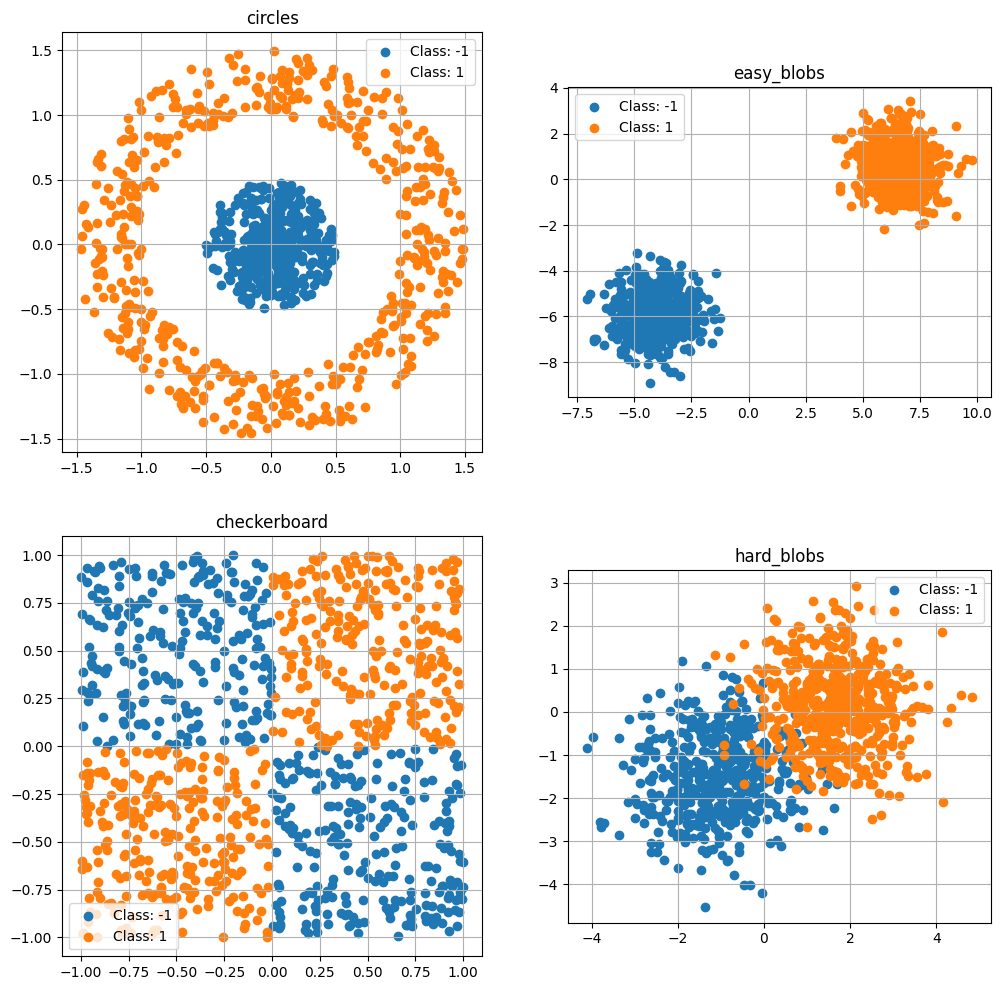

In [8]:
def plot_dataset(dataset, ax=None, title=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    classes = np.unique(dataset.labels)
    classes = np.sort(classes)
    for c in classes:
        ax.scatter(
            dataset.features[dataset.labels == c, 0],
            dataset.features[dataset.labels == c, 1],
            label=f'Class: {c}',
        )
    ax.set_aspect('equal')
    if title is None:
        title = dataset.name
    ax.set_title(title)
    ax.legend()

figure, axes = plt.subplots(2, 2, figsize=(12, 12))
plot_dataset(circles, ax=axes[0, 0])
plot_dataset(easy_blobs, ax=axes[0, 1])
plot_dataset(checkerboard, ax=axes[1, 0])
plot_dataset(hard_blobs, ax=axes[1, 1])

# Rosenblatt Perceptron

For a shorter notation, lets use the following abbreviations ($\tilde{\mathbf{x}}_n$ is an "augmented vector"):
\begin{align}
\tilde{\mathbf{w}} &= \begin{pmatrix}\mathbf w \\ w_0\end{pmatrix}, &
\tilde{\mathbf{x}}_n &= \begin{pmatrix}\mathbf x_n \\ 1\end{pmatrix}
\end{align}

Apply the Rosenblatt criterion to each of the datasets:
\begin{align}
J(\tilde{\mathbf{w}}) &= -\frac 1 N \sum_{n=1}^N \left(\frac{c_n - \hat c_n}{2}\right) \tilde{\mathbf{w}}^{\mathsf T} \tilde{\mathbf{x}}_n
\end{align}

- Make sure to use some stopping criterion to avoid infinite loops.
- Plot the training loss over iterations.
- For which of the datasets does the training converge?

Before you start, think about the following:
What are the varaiable `x`, `x_tilde` and `w_tilde`
in the code and what are the shapes of them? i.e. think about the relation to the math variables $\mathbf{x}_n$, $\tilde{\mathbf{x}}_n$ and $\tilde{\mathbf{w}}$.

In [9]:
def add_augmentation(x):
    """
    ??? Add a doc string. What does this function do? What are the input parameters? Which shape?
    
    Augmented vector: https://en.wikipedia.org/wiki/Affine_transformation#Augmented_matrix
    """
    N = x.shape[0]  # REPLACE
    return np.concatenate([x, np.ones((N, 1))], axis=-1)  # REPLACE return ???

def remove_augmentation(x_tilde):
    """
    ??? Add a doc string. What does this function do? What are the input parameters? Which shape?
    """
    return x_tilde[:, :-1]  # REPLACE return ???

In [10]:
def predict_rosenblatt_perceptron(x_tilde, w_tilde, transform_fn=None):
    """
    ??? Add a doc string. What does this function do? What are the input parameters? Which shape?
    """
    if transform_fn is not None:
        x = remove_augmentation(x_tilde)
        x = transform_fn(x)
        x_tilde = add_augmentation(x)
    
    discriminant = np.einsum('d,nd->n', w_tilde, x_tilde)  # REPLACE discriminant = ???
    prediction = map_0_1_to_minus_1_1(discriminant > 0)  # REPLACE prediction = ???
    # prediction = np.sign(discriminant)  # alternative solution (error at 0 doesn't hurt)  # REPLACE
    return discriminant, prediction

In [11]:
def fit_rosenblatt_perceptron(dataset, iterations=1000, learning_rate=0.1, transform_fn=None):
    """
    ??? Add a doc string. What does this function do? What are the input parameters? Which shape?
    """
    loss_history = np.full(iterations, np.nan)
    N = dataset.features.shape[0]
    
    x = dataset.features
    
    if transform_fn is not None:
        x = transform_fn(dataset.features)
        
    x_tilde = add_augmentation(x)
    
    w_tilde = np.random.normal(size=x_tilde.shape[-1])
    c = dataset.labels
    for iteration in range(iterations):
        discriminant, c_hat = predict_rosenblatt_perceptron(x_tilde, w_tilde)  # transform_fn not nessesary, since is transformed
        loss_history[iteration] = -1 / N * np.einsum('n,d,nd->', (c - c_hat) / 2, w_tilde, x_tilde)  # REPLACE loss_history[iteration] = ???
        # loss_history[iteration] = - np.mean((c - c_hat) / 2 * discriminant)  # alternative solution  # REPLACE
        w_tilde = w_tilde + learning_rate * 1 / N * np.einsum('n,nd->d', (c - c_hat) / 2, x_tilde)  # REPLACE w_tilde = ???
        # w_tilde = w_tilde + learning_rate * np.mean((c - c_hat)[..., None] / 2 * x_tilde  # alternative solution  # REPLACE
    return w_tilde, loss_history

In [12]:
def compute_complete_grid(xlim, ylim, steps):
    """
    ??? Add a doc string. What does this function do? What are the input parameters? Which shape?
    """
    x, y = np.meshgrid(
        np.linspace(*xlim, steps),
        np.linspace(*ylim, steps),
    )
    return x, y, np.stack([x, y], axis=-1)

def fit_and_plot(dataset, transform_fn=None, fit_function=fit_rosenblatt_perceptron, 
                 levels=[0],  # used later for SVM
                 **kwargs):
    """
    ??? Add a doc string. What does this function do? What are the input parameters? Which shape?
    """
    w_tilde, loss_history = fit_function(
        dataset,
        transform_fn=transform_fn,
        **kwargs,
    )
    
    _, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot loss history
    axes[0].plot(loss_history)
    axes[0].set_title('{}, final loss: {}'.format(dataset.name, loss_history[-1]))
    # Use log scale above 1e-5 and linear scale below
    axes[0].set_yscale("symlog", linthresh=1e-5)
    
    
    # Plot decision boundary if in area
    steps = 100
    x, y, features_grid = compute_complete_grid(
        (np.min(dataset.features[:, 0]), np.max(dataset.features[:, 0])),
        (np.min(dataset.features[:, 1]), np.max(dataset.features[:, 1])),
        steps=steps
    )
    features_grid = features_grid.reshape(steps * steps, 2)
    features_grid = add_augmentation(features_grid)
    z, _ = predict_rosenblatt_perceptron(features_grid, w_tilde, transform_fn=transform_fn)
    z = np.reshape(z, (steps, steps))
    
    if np.any(z < 0) and np.any(z > 0):
        axes[1].contourf(x, y, z >= 0, colors=['cyan', 'yellow'], alpha=0.2)
        plot_dataset(dataset, ax=axes[1])
        axes[1].contour(x, y, z, levels=levels)
    else:
        axes[1].contourf(x, y, z >= 0, colors=['cyan', 'yellow'],  alpha=0.2)
        plot_dataset(dataset, ax=axes[1])
        axes[1].contour(x, y, z)
    plt.show()
    
    print('w_tilde', w_tilde)

- Which datasets are linearly separable?
- Explain the loss curve for the non linearly separable datasets.
- Is the loss curve an indicator if the we can get a reasonable discriminant for non linearly separable datasets?

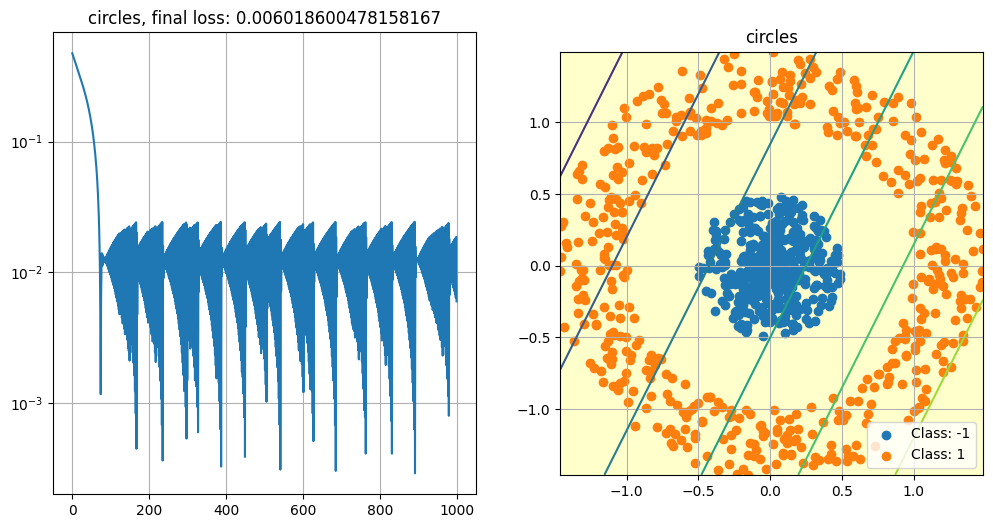

w_tilde [ 0.00221856 -0.00111182  0.03844298]


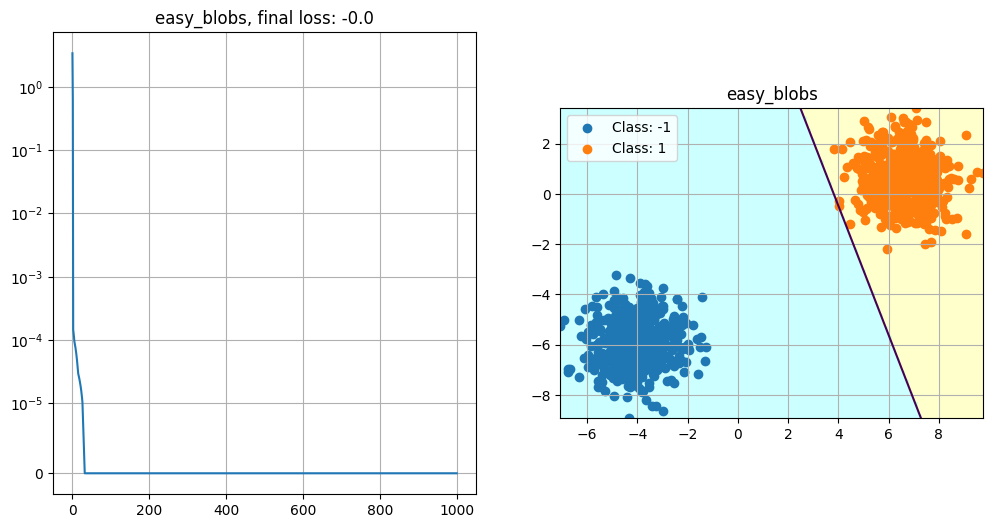

w_tilde [ 0.369542    0.14371413 -1.4102449 ]


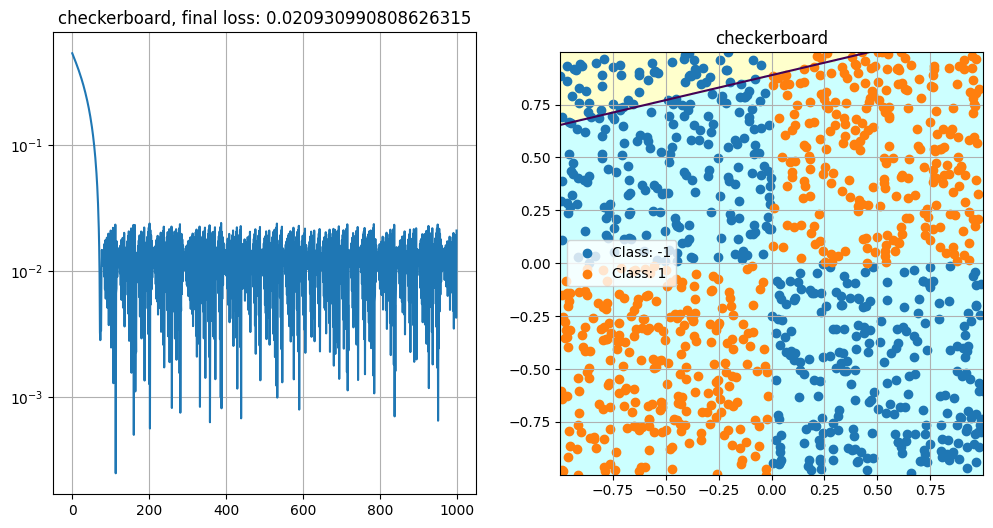

w_tilde [-0.00125142  0.00531102 -0.00472104]


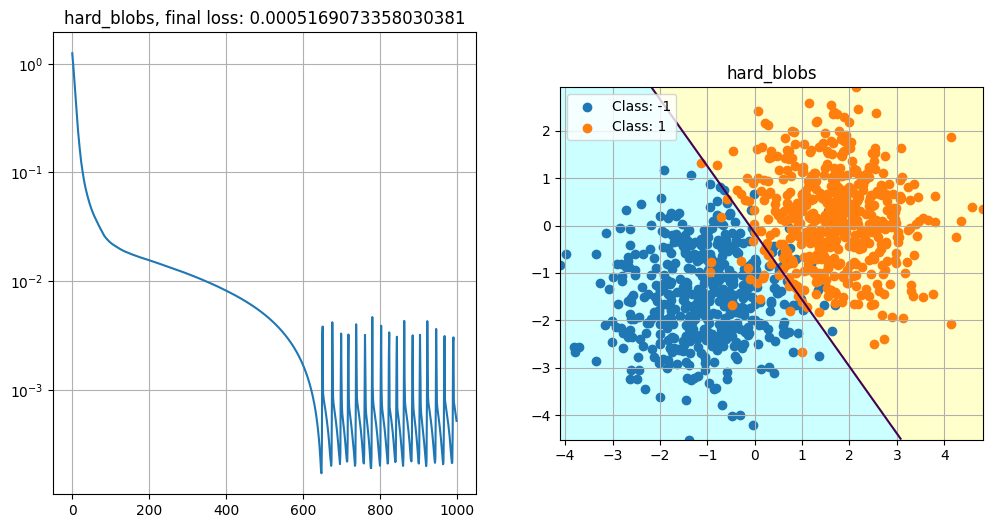

w_tilde [0.02172692 0.01540064 0.00240258]


In [13]:
fit_and_plot(circles)
fit_and_plot(easy_blobs)
fit_and_plot(checkerboard)
fit_and_plot(hard_blobs)

# Feature transformation

Which hand-crafted feature transformation is necessary to render the `circles` and `checkerboard` datasets linearly separable? Train a Rosenblatt perceptron using this transformation. Plot the trainig loss over iterations.

- Analyse the decision boundarys.
- Which solution generalizes better?
- For which dataset do you expect a better solution from SVM?

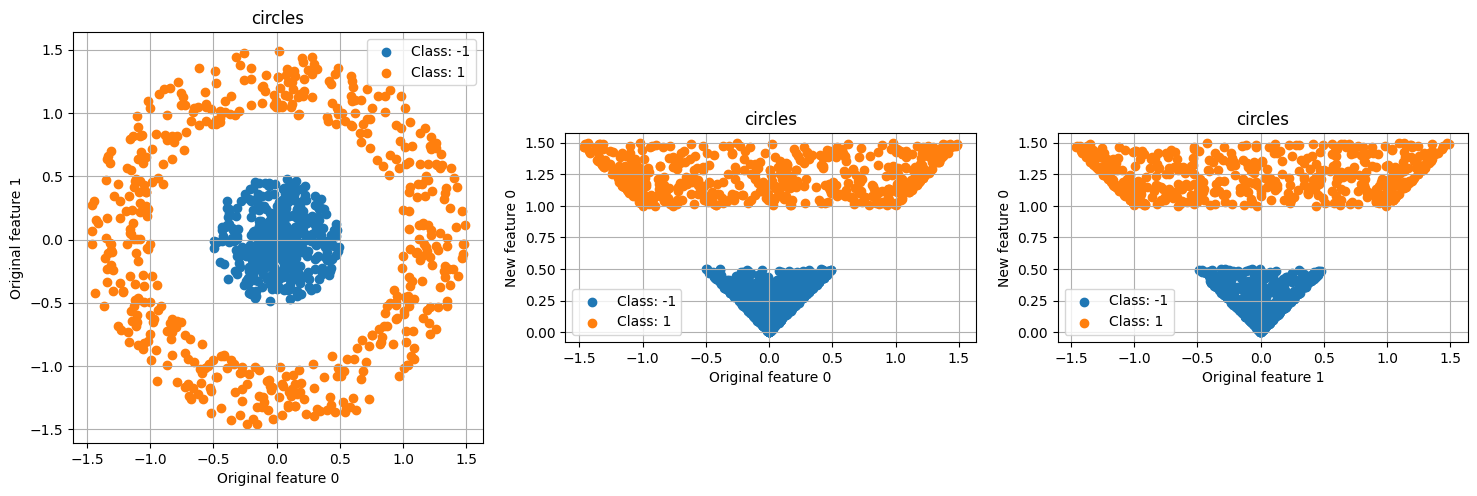

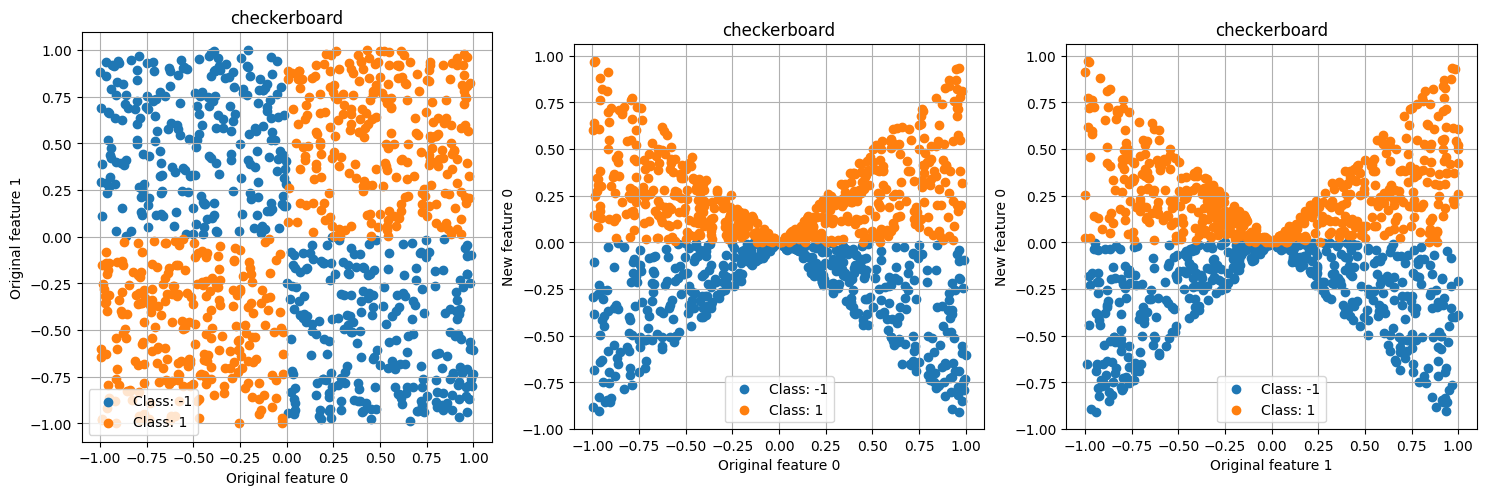

In [14]:
def plot_transformed_features_dataset(dataset, transform_fn, ax=None):
    transformed_features = add_augmentation(transform_fn(dataset.features))
    # Add the original features to see the plots for old vs new feature. 
    transformed_features = np.concatenate([dataset.features, transformed_features], axis=-1)
    
    if transformed_features.shape[-1] in [2, 3]:
        _, ax = plt.subplots(1, 1, figsize=(6, 6))
        transformed = Dataset(transformed_features, dataset.labels)
        plot_dataset(transformed, ax)
    elif 8 > transformed_features.shape[-1] > 2:
        # This "elif" does the same as the "if", except
        # that it will plot each parameter combination.
        combinations = list(itertools.combinations(range(transformed_features.shape[-1]-1), 2))        
        nrows, ncols = (len(combinations)+2) // 3, 3
        _, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 6*nrows), squeeze=False)
        for (i, j), ax in zip(combinations, axes.ravel()):
            transformed = Dataset(dataset.name, transformed_features[..., [i, j]], dataset.labels)
            plot_dataset(transformed, ax)
            ax.set_xlabel(f'Original feature {i}' if i < 2 else f'New feature {i-2}')
            ax.set_ylabel(f'Original feature {j}' if j < 2 else f'New feature {j-2}')
    else:
        raise RuntimeError(transformed_features.shape)
    
plot_transformed_features_dataset(
    circles, 
    transform_fn=lambda x: np.linalg.norm(x, axis=-1, keepdims=True),  # REPLACE transform_fn=lambda x: ???
)
plot_transformed_features_dataset(
    checkerboard, 
    transform_fn=lambda x: np.prod(x, axis=-1, keepdims=True),  # REPLACE transform_fn=lambda x: ???
)

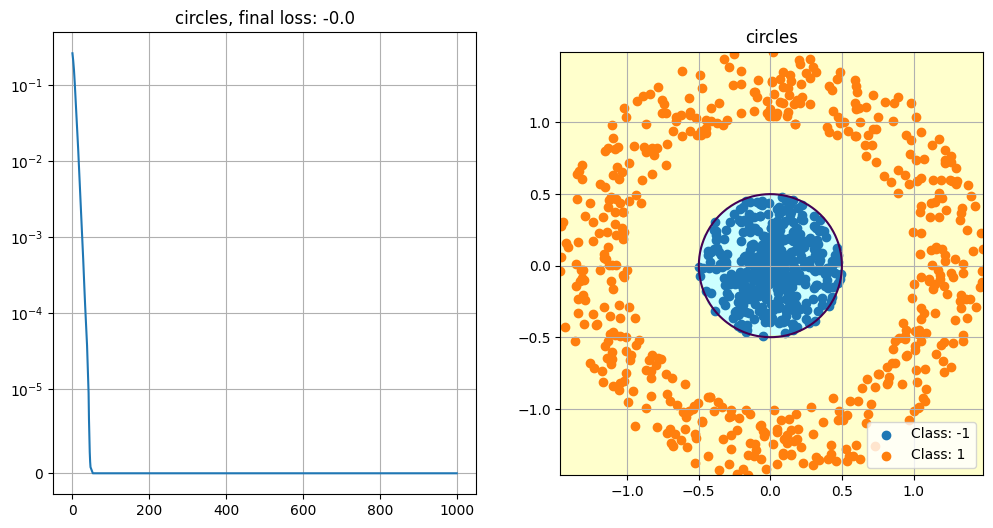

w_tilde [ 0.90175195 -0.44993126]


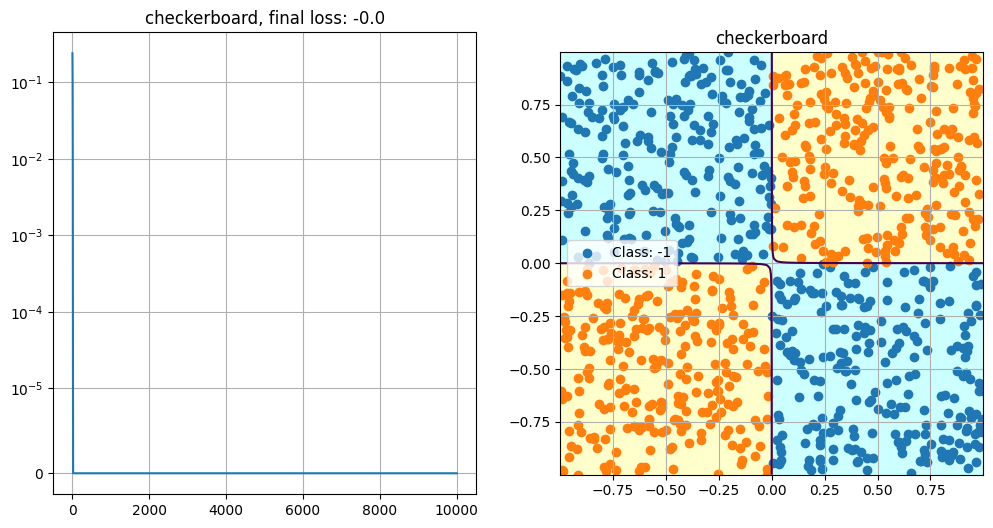

w_tilde [ 3.09416073e-01 -6.86145952e-05]


In [15]:
fit_and_plot(
    circles,
    transform_fn=lambda x: np.linalg.norm(x, axis=-1, keepdims=True),  # REPLACE transform_fn=lambda x: ???
)
fit_and_plot(
    checkerboard,
    iterations=10000,
    transform_fn=lambda x: np.prod(x, axis=-1, keepdims=True),  # REPLACE transform_fn=lambda x: ???
)

# Support vector machine

Train an SVM using gradient descent. For which datasets does the algorithm converge?

\begin{align}
	\tilde{\mathcal{L}}(\mathbf{w},w_0) = \frac{\|\mathbf{w}\|^2}{2} + \frac C N \sum_{n=1}^N \max\left(0, 1 - c_n(\mathbf{w}^{\mathsf T}\mathbf{x}_n+w_0) \right).
\end{align}


Text from SML script to this equation (Eq. 4.36):

> The first term will push the model to have a small weight vector $\mathbf w$, leading to a large
margin, while the second term computes the total of all margin violations. Minimizing
this term ensures that the model makes the margin violations as small and as few as
possible. $C$ is a trade-off parameter between the two contributions to the cost function.
This objective function can be minimized by gradient descent.
>
> By the way, the function max(0, 1−x) is the hinge loss we have seen earlier in Section 2.7.3

Apply the same feature transform as before to render the `circles` and `checkerboard` dataset linearly separable.



The gradients are:
\begin{align}
\frac{\partial J}{\partial \mathbf w} &= \mathbf w + \frac C N \sum_{n=1}^N -c_n \mathrm{heaviside}\bigg(1 - c_n(\mathbf{w}^{\mathsf T}\mathbf{x}_n+w_0)\bigg) \mathbf x_n \\
\frac{\partial J}{\partial w_0} &= \frac C N \sum_{n=1}^N -c_n \mathrm{heaviside}\bigg(1 - c_n(\mathbf{w}^{\mathsf T}\mathbf{x}_n+w_0)\bigg)
\end{align}

In [16]:
def fit_support_vector_machine(dataset, transform_fn=None, iterations=10000,
                               learning_rate=0.01, hinge_loss_weight=10):
    loss_history = np.empty(iterations)
    loss_history[:] = np.nan
    N = dataset.features.shape[0]
    x_tilde = add_augmentation(dataset.features)
    
    if transform_fn is not None:
        x = remove_augmentation(x_tilde)
        x = transform_fn(x)
        x_tilde = add_augmentation(x)
    
    w_tilde = np.random.normal(size=x_tilde.shape[-1])
    c = dataset.labels
    for iteration in range(iterations):
        discriminant, c_hat = predict_rosenblatt_perceptron(x_tilde, w_tilde)
        z = 1 - c * discriminant  # REPLACE
        loss_history[iteration] = np.linalg.norm(w_tilde[:-1]) / 2 + hinge_loss_weight * np.sum(np.maximum(0, z), axis=0)  # REPLACE loss_history[iteration] = ???
        gradient_w = w_tilde[:-1] + hinge_loss_weight / N * np.einsum('n,n,nd->d', np.heaviside(z, 0.5), -c, x_tilde[:, :-1])  # REPLACE gradient_w = ???
        gradient_w_0 = hinge_loss_weight / N * np.einsum('n,n->', np.heaviside(z, 0.5), -c)  # REPLACE gradient_w_0 = ???
        gradient = np.concatenate((gradient_w, [gradient_w_0]))
        w_tilde = w_tilde - learning_rate * gradient
    return w_tilde, loss_history

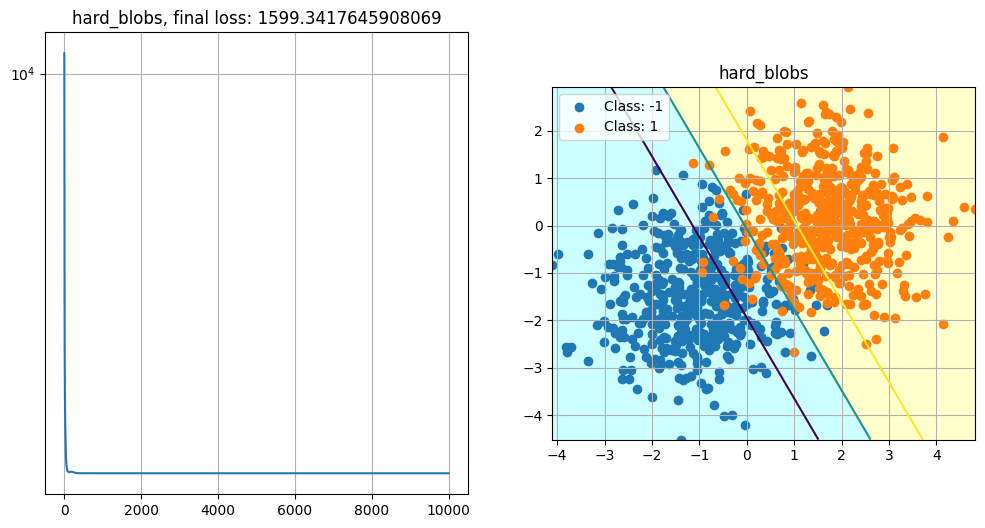

w_tilde [0.90827335 0.53361258 0.0376259 ]


In [17]:
fit_and_plot(
    hard_blobs,
    fit_function=fit_support_vector_machine,
    levels=[-1, 0, 1],
)

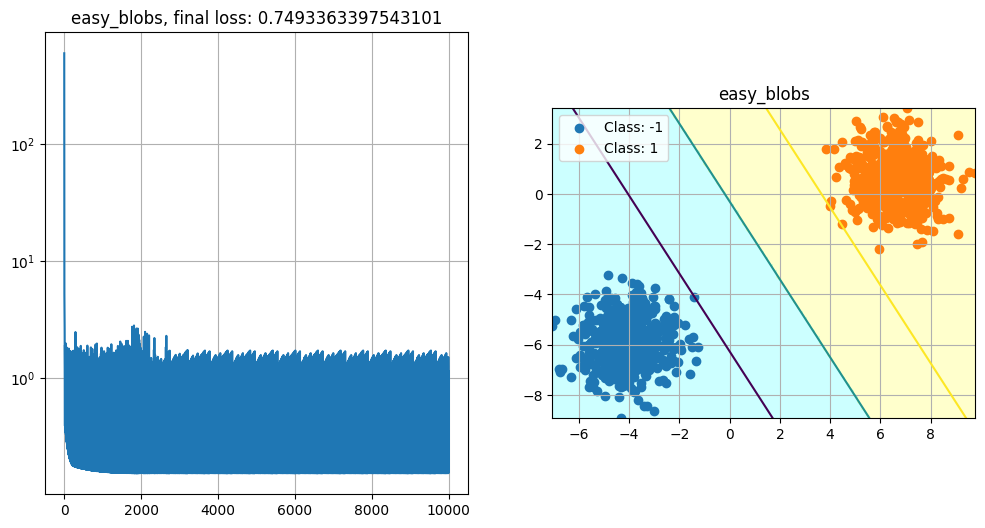

w_tilde [0.25982065 0.16766249 0.05077338]


In [18]:
fit_and_plot(
    easy_blobs,
    fit_function=fit_support_vector_machine,
    levels=[-1, 0, 1],
    iterations=10000,  # REPLACE iterations=???,
    hinge_loss_weight=100,  # REPLACE hinge_loss_weight=???,
    learning_rate=0.01,  # REPLACE learning_rate=???,
)

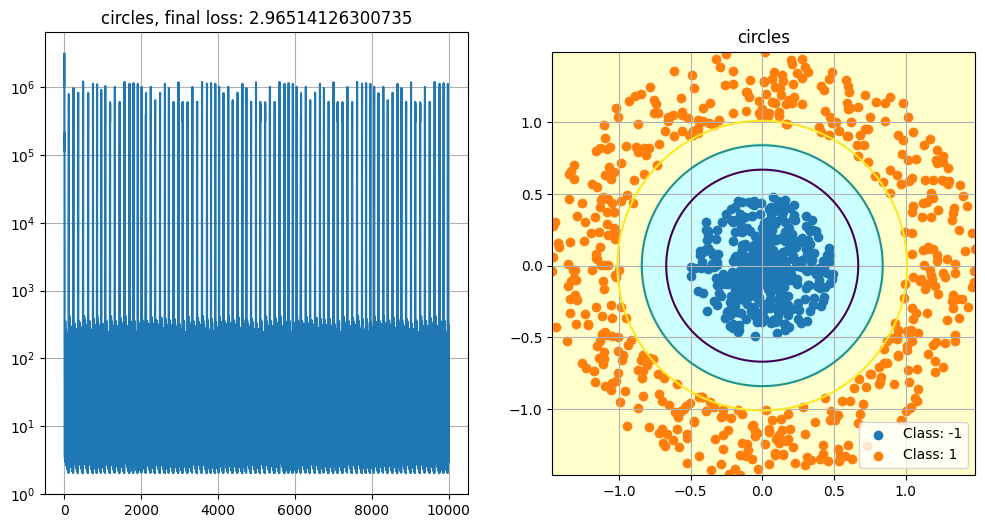

w_tilde [ 5.8709797  -4.93165516]


In [19]:
fit_and_plot(
    circles,
    fit_function=fit_support_vector_machine,
    levels=[-1, 0, 1], 
    transform_fn=lambda x: np.linalg.norm(x, axis=-1, keepdims=True),  # REPLACE transform_fn=lambda x: ???,
    hinge_loss_weight=1000  # REPLACE hinge_loss_weight=???
)

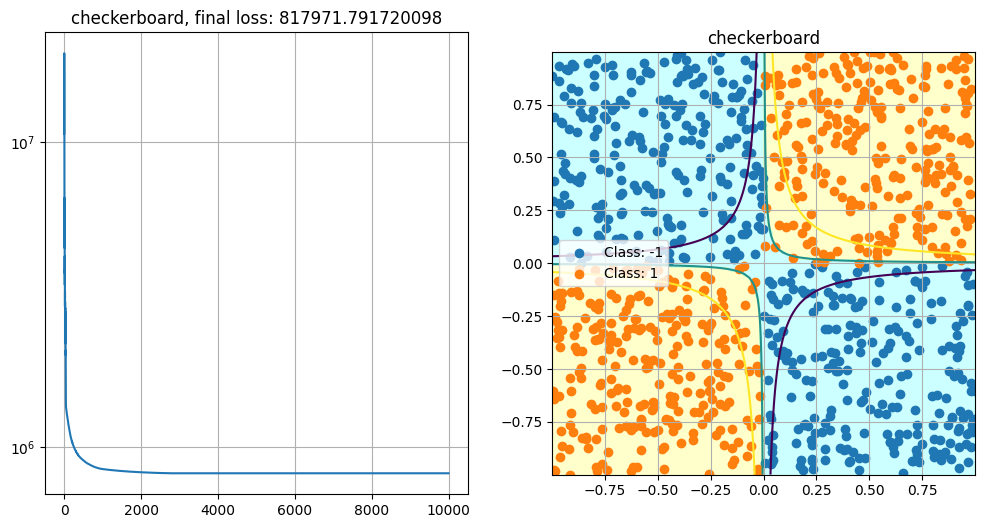

w_tilde [26.76943348 -0.12477127]


In [20]:
fit_and_plot(
    checkerboard,
    fit_function=fit_support_vector_machine,
    transform_fn=lambda x: np.prod(x, axis=-1, keepdims=True),  # REPLACE transform_fn=lambda x: ???,
    iterations=10000,  # REPLACE iterations=???,
    learning_rate=0.001,  # REPLACE learning_rate=???,
    hinge_loss_weight=10000,  # REPLACE hinge_loss_weight=???,
    levels=[-1, 0, 1],
)

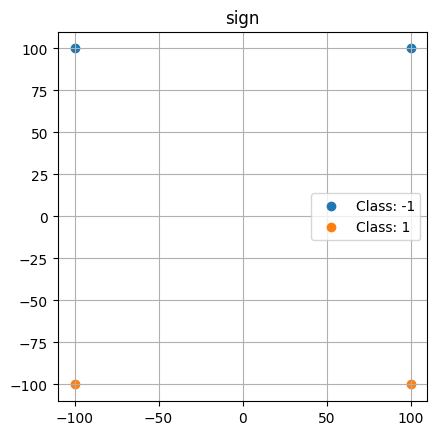

In [21]:
sign_dataset = Dataset('sign', np.array([[1, 1], [-1, 1], [1, -1], [-1, -1]]) * 100, np.array([-1, -1, 1, 1]))
plot_dataset(sign_dataset)

- How should the decision boundary look like?
- Can you explain, why the SVM code does not work for this simple example?

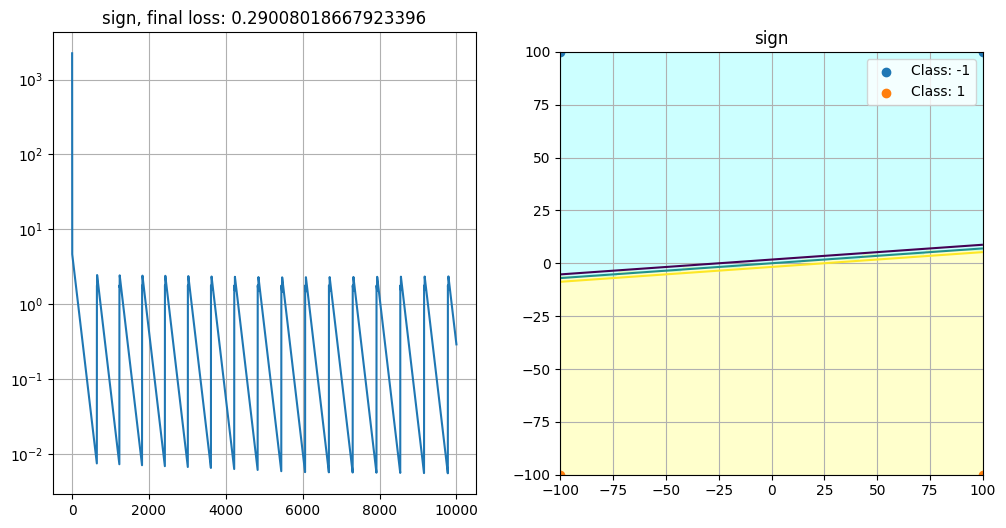

w_tilde [ 0.04024752 -0.57294689  0.00590039]


In [22]:
fit_and_plot(
    sign_dataset,
    fit_function=fit_support_vector_machine,
    levels=[-1, 0, 1],
)

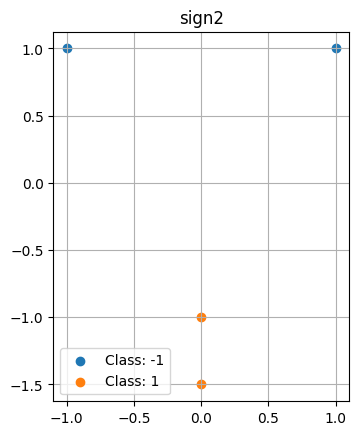

In [23]:
sign_dataset2 = Dataset('sign2', np.array([[1, 1], [-1, 1], [0, -1], [0, -1.5]]), np.array([-1, -1, 1, 1]))
plot_dataset(sign_dataset2)

- How should the decision boundary look like?
- Can you explain, why the decision boundary is not the expected one?

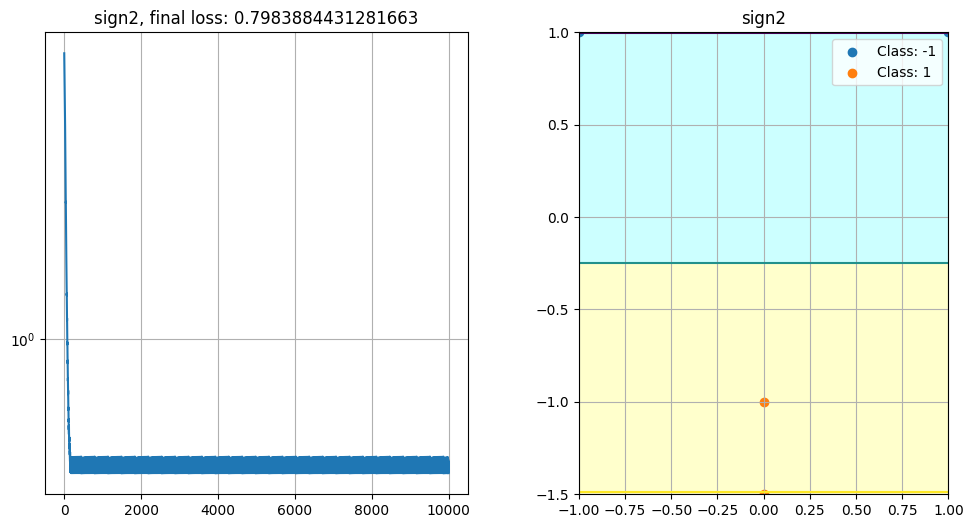

w_tilde [-2.11154809e-47 -7.97174562e-01 -1.97239232e-01]


In [24]:
fit_and_plot(
    sign_dataset2,
    fit_function=fit_support_vector_machine,
    hinge_loss_weight=1,
    levels=[-0.99, 0, 0.99],
)

# SVM with sklearn

Use the SVM from `sklearn` (https://scikit-learn.org/stable/index.html) to classify the datasets.

The documentation is here
- Theory: https://scikit-learn.org/stable/modules/svm.html#svc
- Code: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC

The `sklearn.svm.SVC` class implements a support vector machine for classification.
- What algorithm does `SVC` implement? How does it differ from the one you implemented above?
- Fit the SVM with the different kernels provided by sklearn. Which kernels work for which datasets?
- Compare the results you obtained above with the ones obtained with sklearn

In [25]:
from sklearn.svm import SVC

In [26]:
def plot_svm_decision_boundary(
    dataset, title, svm, ax: plt.Axes=None
):
    """
    ??? Add a doc string. What does this function do? What are the input parameters? Which shape?
    """    
    show = False
    if ax is None:
        show = True
        _, ax = plt.subplots(1, 1, figsize=(12, 6))
    
    # Plot decision boundary if in area
    steps = 100
    x, y, features_grid = compute_complete_grid(
        (np.min(dataset.features[:, 0]), np.max(dataset.features[:, 0])),
        (np.min(dataset.features[:, 1]), np.max(dataset.features[:, 1])),
        steps=steps
    )
    
    features_grid = features_grid.reshape(steps * steps, 2)
    z = svm.predict(features_grid)
    z = np.reshape(z, (steps, steps))
    
    ax.contourf(x, y, z, colors=['cyan', 'yellow'], alpha=0.2)
    plot_dataset(dataset, ax=ax, title=title)
    ax.contour(x, y, z, levels=[0])
    if show:
        plt.show()

In [27]:
def fit_and_plot_svm(dataset, kernel='linear', ax=None, **kwargs):
    """
    ??? Add a doc string. What does this function do? What are the input parameters? Which shape?
    """
    svm = SVC(kernel=kernel, **kwargs) # REPLACE svm = ???
    svm.fit(dataset.features, dataset.labels) # REPLACE 
    
    plot_svm_decision_boundary(dataset, title=f'{dataset.name} {kernel}', svm=svm, ax=ax)

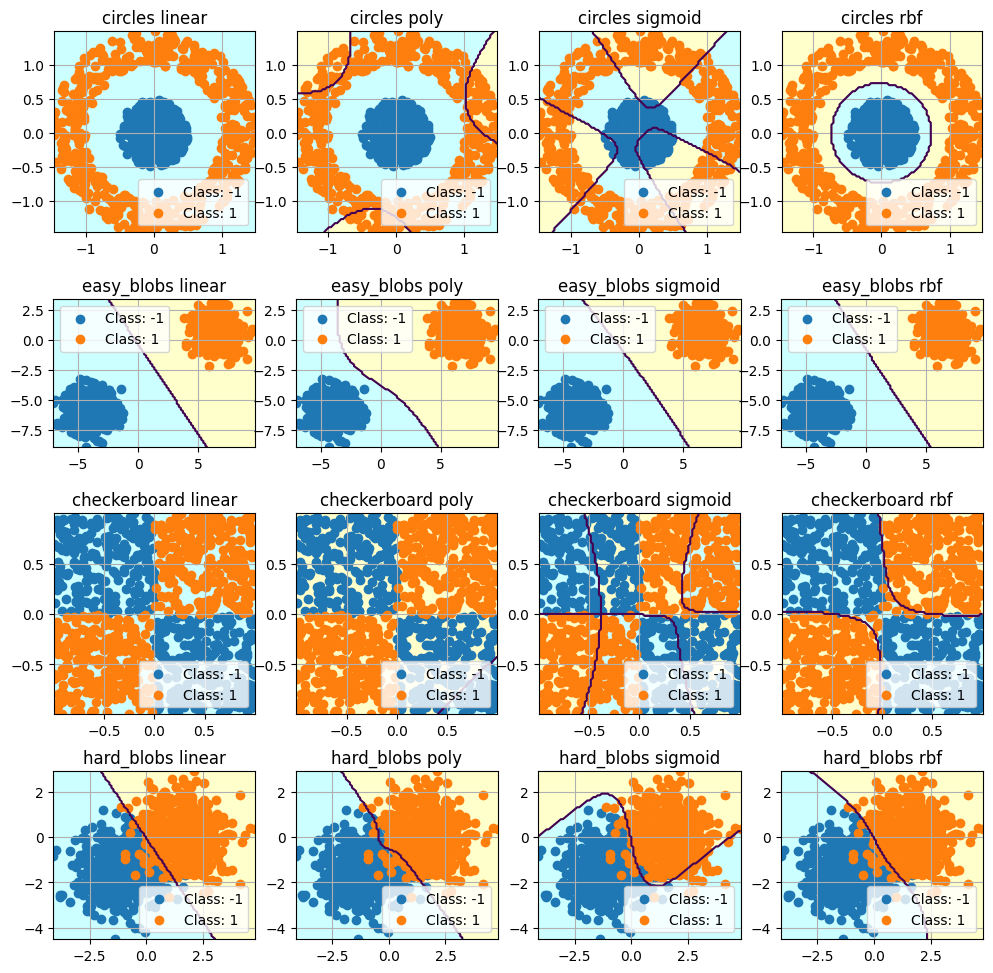

In [28]:
_, axes = plt.subplots(4, 4, figsize=(12, 12))
for i, dataset in enumerate((circles, easy_blobs, checkerboard, hard_blobs)):
    for j, kernel in enumerate(('linear', 'poly', 'sigmoid', 'rbf')):
        fit_and_plot_svm(dataset, kernel=kernel, ax=axes[i,j])
plt.show()

Now, fit the SVM with the transform functions you used above. 
- Sklearn takes a kernel function instead of a transform function
- The kernel function takes feature matrices `d1` and `d2` instead of a single data point

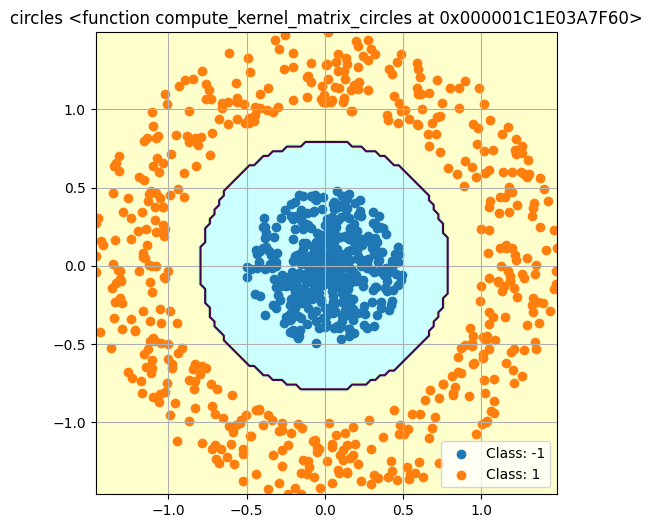

In [29]:
def compute_kernel_matrix_circles(d1, d2):
    """
    Args:
        d1: First data matrix, shape (n_samples, n_features)
        d2: Second data matrix, shape (n_samples, n_features)
        
    Returns:
        kernel_matrix, shape (n_samples, n_samples)
    """
    x1 = np.sum(d1**2, axis=-1) # REPLACE
    x2 = np.sum(d2**2, axis=-1) # REPLACE
    kernel_matrix = x1[:, None] * x2[None, :]  # REPLACE kernel_matrix = ???
    return kernel_matrix
fit_and_plot_svm(circles, kernel=compute_kernel_matrix_circles)

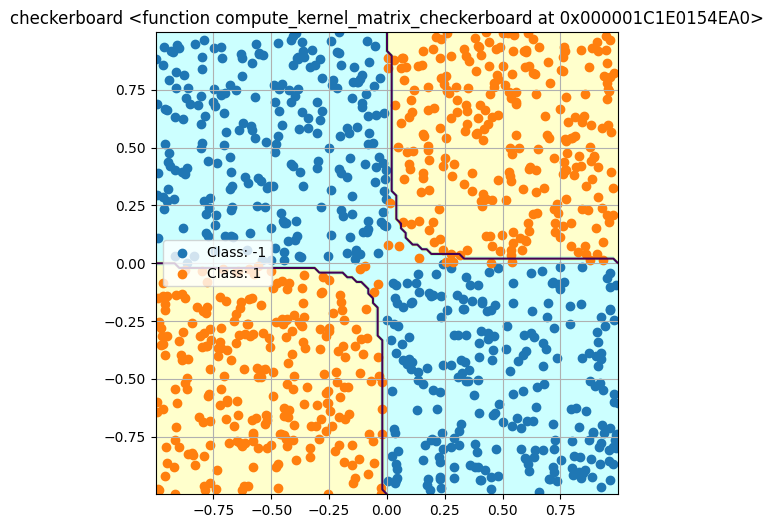

In [30]:
def compute_kernel_matrix_checkerboard(d1, d2):
    """
    Args:
        d1: First data matrix, shape (n_samples, n_features)
        d2: Second data matrix, shape (n_samples, n_features)
        
    Returns:
        kernel_matrix, shape (n_samples, n_samples)
    """
    x1 = np.prod(d1, axis=-1) # REPLACE
    x2 = np.prod(d2, axis=-1) # REPLACE
    kernel_matrix = x1[:, None] * x2[None, :] # REPLACE kernel_matrix = ???
    return kernel_matrix
fit_and_plot_svm(checkerboard, kernel=compute_kernel_matrix_checkerboard)

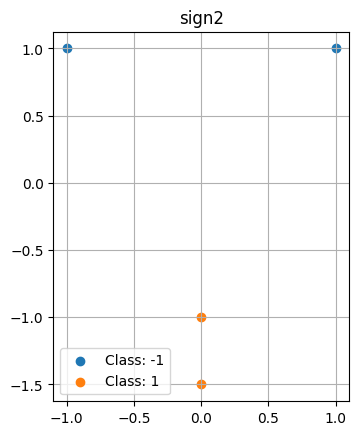

In [31]:
sign_dataset3 = Dataset('sign3', np.array([[1, 1], [-1, 1], [0, -1], [0, -1.5]])/100, np.array([-1, -1, 1, 1]))
plot_dataset(sign_dataset2)

- How should the decision boundary look like?
- Can you explain, why the decision boundary is not the expected one?
- Can you find hyperparameters so that the SVM finds the expected decision boundary?

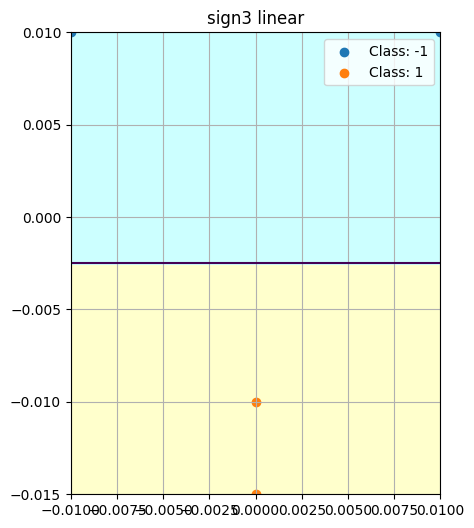

In [32]:
fit_and_plot_svm(sign_dataset3, kernel='linear')

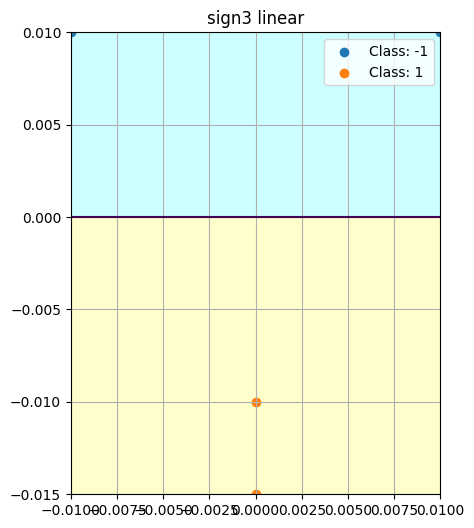

In [33]:
fit_and_plot_svm(sign_dataset3, kernel='linear', C=10000)  # REPLACE fit_and_plot_svm(sign_dataset3, kernel='linear', ???)

# For experts...

- Mark the support vectors in your diagrams.
- What is the advantage of training the SVM with gradient descent?